# Occlusion experiment

In [1]:
import sys
sys.path.append("../src")

%load_ext autoreload
%autoreload 2

In [2]:
import os
import json

import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import seaborn as sns
from matplotlib.image import imread

from input_utils import preprocess_image_for_visualization, normalize_image
from slim_models.nets import nets_factory
from models import model_fn
from tools.utils import ImageDecoder

%matplotlib inline

In [3]:
class_id_filepath = "../data/interim/real_crop_v1/class.json"
with open(class_id_filepath, "rt") as f:
    name_to_class_id = json.loads(f.read())

id_to_class_name = {v: k for k, v in name_to_class_id.items()}

In [13]:
params = {
    "num_classes": 13,
    "network_name": "nasnet_large",
    "output_type": "softmax"
}

### Read image and do initial cropping

In [7]:
image_path = "/home/ubuntu/Pictures/images/out_012.jpg"
image_str = tf.read_file(image_path)
image_decoded = tf.image.decode_image(image_str, channels=3)
with tf.Session() as sess_img:
    image = sess_img.run(image_decoded)

(331, 331, 3)


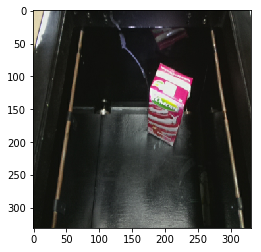

In [8]:
image_pld = tf.placeholder(tf.uint8, shape=[None, None, 3])
cropped_image = preprocess_image_for_visualization(image_pld, 
                                                   network_name=params["network_name"])

with tf.Session() as sess_img:
    output = sess_img.run(cropped_image, feed_dict={image_pld: image})
    
output_image = output.astype(np.uint8)
plt.imshow(output_image)
print(output_image.shape)

### Create occluded images

In [9]:
images = [output]
image_size = output.shape[0]
if params["network_name"] == "resnet_v1_101":
    size = 56
    stride = 6
else:
    size = 101
    stride = 10
for i in range(0, image_size - size + 1, stride):
    for j in range(0, image_size - size + 1, stride):
        occluded_image = output.copy()
        occluded_image[i: i + size, j: j + size, :] = 127
        images.append(occluded_image)
        
images = np.array(images)
images.shape

(577, 331, 331, 3)

### Run estimator

In [10]:
def input_fn(images, network_name="resnet_v1_101"):
    dataset = tf.data.Dataset.from_tensor_slices(images)
    
    dataset = dataset.map(lambda image: normalize_image(image, network_name))
    dataset = dataset.batch(batch_size=32)
    iterator = dataset.make_one_shot_iterator()
    features = {
        "image": iterator.get_next()
    }
    return features, None

In [14]:
model_dir = "../logs/CROP_NEW_00/"
estimator = tf.estimator.Estimator(model_fn, model_dir=model_dir, params=params)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_save_summary_steps': 100, '_global_id_in_cluster': 0, '_keep_checkpoint_max': 5, '_model_dir': '../logs/CROP_NEW_00/', '_keep_checkpoint_every_n_hours': 10000, '_is_chief': True, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f718006b240>, '_log_step_count_steps': 100, '_save_checkpoints_steps': None, '_master': '', '_task_type': 'worker', '_session_config': None, '_save_checkpoints_secs': 600, '_task_id': 0, '_tf_random_seed': None, '_num_worker_replicas': 1, '_service': None, '_evaluation_master': '', '_num_ps_replicas': 0}


In [15]:
probs = []
class_ids = []
for pred in estimator.predict(input_fn=lambda: input_fn(images, network_name=params["network_name"])):
    class_ids.extend(pred['class_id'].tolist())
    probs.append(pred['probs'])
    
class_id = class_ids[0]
prob = probs[0][0][class_id]
print("Predicted class {}: {} with prob {}".format(class_id, id_to_class_name[class_id], prob))

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Scale of 0 disables regularizer.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ../logs/CROP_NEW_00/model.ckpt-60000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Predicted class 6: HopCarton with prob 0.4254567325115204


In [16]:
# class_id = 17
output_shape = ((images.shape[1] - size) // stride + 1, 
                (images.shape[2] - size) // stride + 1)
heat = np.array([example[class_id] 
                 for p in probs 
                 for example in p][1:]).reshape(output_shape)
print("Predicted and max confidence:", probs[0][0][class_id], np.max(heat))

Predicted and max confidence: 0.42545673 0.91596967


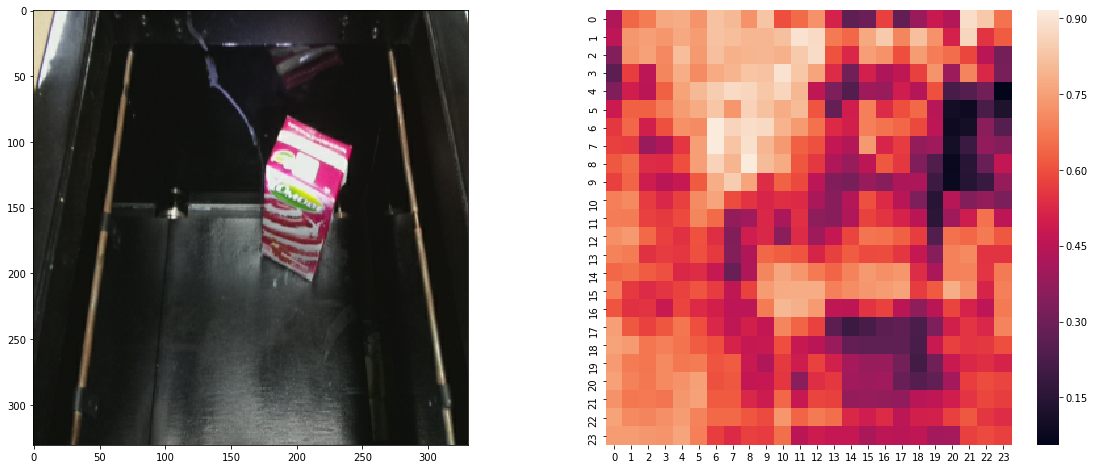

In [17]:
fig, axs = plt.subplots(1, 2, figsize=(20, 8))
axs[0].imshow(images[0].astype(np.uint8))
sns.heatmap(heat, ax=axs[1])

Text(0.5,1,'Confidence: 0.190343')

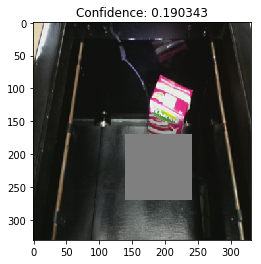

In [23]:
i = 17 * output_shape[0] + 1 + 14
plt.imshow(images[i].astype(np.uint8))
plt.title("Confidence: {:.6f}".format(heat[(i - 1) // output_shape[0], 
                           (i - 1) % output_shape[0]]))

# Saliency map

In [28]:
from slim_models.nets.nets_factory import get_network_fn

#### Create noisy images

In [45]:
noise_level = 0.2
num_noises = 50
noises = output.copy()
noises = noises[np.newaxis, ...] * np.ones((num_noises, *noises.shape))
sigma = noise_level * 255

noises = noises + np.random.randn(*noises.shape) * sigma

In [46]:
def input_fn_pld(images, network_name="resnet_v1_101"):
    dataset = tf.data.Dataset.from_tensor_slices(images)
    
    dataset = dataset.map(lambda image: normalize_image(image, network_name))
    dataset = dataset.batch(batch_size=8)
    iterator = dataset.make_initializable_iterator()
    features = {
        "image": iterator.get_next()
    }
    return features, None, iterator

In [47]:
graph = tf.Graph()
with graph.as_default():
    image_pld = tf.placeholder(tf.float32, [None, output_image.shape[0], 
                                            output_image.shape[1], 3])
    class_id_pld = tf.placeholder(tf.int32, [])
    features, labels, iterator = input_fn_pld(image_pld)
    image_tensor = features["image"]
    network_fn = get_network_fn(params["network_name"], params["num_classes"],
                                is_training=False)
    logits, _ = network_fn(image_tensor)
    s = tf.slice(logits, 
                 begin=[0, class_id_pld], 
                 size=[-1, 1])
    s0 = logits[0][class_id_pld]
    grads = tf.gradients(s, image_tensor)

INFO:tensorflow:Scale of 0 disables regularizer.


INFO:tensorflow:Scale of 0 disables regularizer.


INFO:tensorflow:A GPU is available on the machine, consider using NCHW data format for increased speed on GPU.


INFO:tensorflow:A GPU is available on the machine, consider using NCHW data format for increased speed on GPU.


In [48]:
with graph.as_default():
    sess = tf.Session(graph=graph)
    save_path = "../logs/NODROP06/model.ckpt-12914"
    saver = tf.train.Saver()
    saver.restore(sess, save_path)

INFO:tensorflow:Restoring parameters from ../logs/NODROP06/model.ckpt-12914


INFO:tensorflow:Restoring parameters from ../logs/NODROP06/model.ckpt-12914


In [57]:
gs = None
sess.run(iterator.initializer, feed_dict={image_pld: noises})
while True:
    try:
        g = sess.run(grads, feed_dict={class_id_pld: 17})
        if gs is None:
            gs = g[0]
        else:
            gs = np.concatenate((gs, g[0]))
    except Exception as e:
        break
        
gs.shape

End of sequence
	 [[Node: IteratorGetNext = IteratorGetNext[output_shapes=[[?,331,331,3]], output_types=[DT_FLOAT], _device="/job:localhost/replica:0/task:0/device:CPU:0"](Iterator)]]

Caused by op 'IteratorGetNext', defined at:
  File "/home/ubuntu/.pyenv/versions/3.6.2/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/ubuntu/.pyenv/versions/3.6.2/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/ubuntu/.pyenv/versions/3.6.2/envs/recycle/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/ubuntu/.pyenv/versions/3.6.2/envs/recycle/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/ubuntu/.pyenv/versions/3.6.2/envs/recycle/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 477, in start
    ioloop.IOLoop.instance().start()
  File "/home/ubuntu/.pyenv/versions/3.

(50, 331, 331, 3)

In [58]:
M = gs.copy()
M = np.sum(np.mean(np.abs(M ** 2), axis=0), axis=-1)
max_val = np.percentile(M, 99)
min_val = np.min(M)
M = np.clip((M - min_val) / (max_val - min_val), 0., 1.)

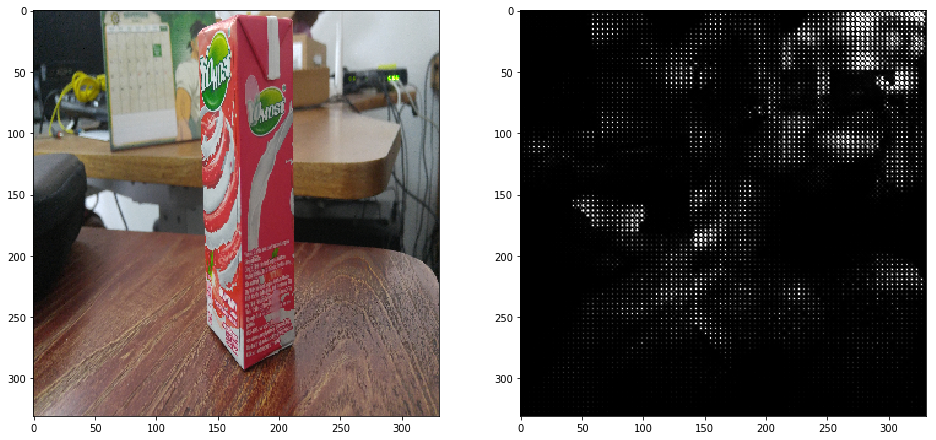

In [59]:
fig, axs = plt.subplots(1, 2, figsize=(16, 8))
axs[0].imshow(output.astype(np.uint8))
axs[1].imshow(M, cmap='gray')

# Use saliency package

In [60]:
import saliency

In [61]:
gradient_saliency = saliency.GradientSaliency(
    graph, sess, s0, image_tensor)

In [62]:
with graph.as_default():
    sess.run(iterator.initializer, feed_dict={image_pld: output_image[np.newaxis, ...]})
    normalized_image = sess.run(image_tensor)
    
    vanilla_mask_3d = gradient_saliency.GetMask(
        normalized_image[0], feed_dict = {class_id_pld: 17})
    smoothgrad_mask_3d = gradient_saliency.GetSmoothedMask(
        normalized_image[0], feed_dict={class_id_pld: 17})

In [63]:
vanilla_mask_grayscale = saliency.VisualizeImageGrayscale(vanilla_mask_3d)
smoothgrad_mask_grayscale = saliency.VisualizeImageGrayscale(smoothgrad_mask_3d)

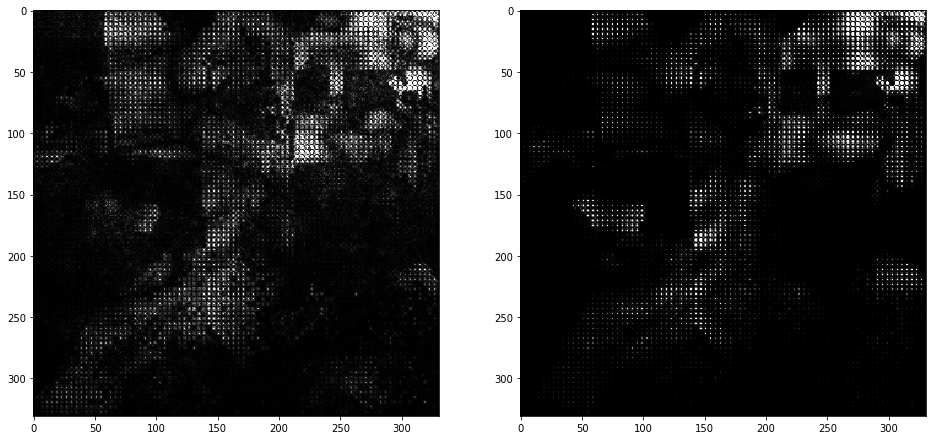

In [64]:
fig, axs = plt.subplots(1, 2, figsize=(16, 8))
axs[0].imshow(vanilla_mask_grayscale, cmap="gray")
axs[1].imshow(smoothgrad_mask_grayscale, cmap="gray")